# Testing crowding in star clusters with ellc third light option

### In ellc.lc.__doc__

```
light_3 : float, optional
      Third light contribution relative to total flux from both stars at 
      time t_zero excluding eclipse effects.
```

* Calculate the surface density and number of stars per resolution element
* Created a single star class (that runs through SED, and gives all the magnitudes and fluxes in each filter)
* Draw and evolve some number of singles stars with COSMIC 
* Draw randomly from this set up to the number of stars per resolution element and sum the fluxes
* Use this to define the third light

### To do
* Add the surface density (and crowding fraction?) to the header of the output file
* Add the third light fraction to each line of the output file
* Decide if I should use the fraction of stars per resolution element to define light_3, or should I draw a random number to see if at least 1 star is actually in the same resolution element.  (I think I should use the fraction, but I shold consult with Adam)
* I need a new file from Andrew with all the masses in there (and of course this means that I will have to rerun all the clusters again, or at least update all the output files)

In [1]:
import ellc

import numpy as np
import pandas as pd
from astropy import units, constants

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBClusterWorker import LSSTEBClusterWorker
from OpSim import OpSim
from getClusterBinaries import getClusterBinaries
from SED import SED

%load_ext autoreload
%autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


### First, let's test the light_3 option in ellc

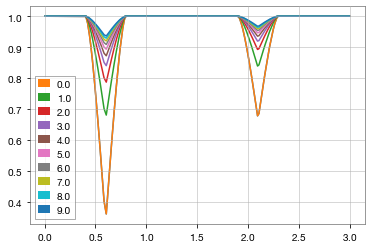

In [2]:
period = 3 #days
r1 = 0.2 #solar radii
r2 = 0.2 #solar radii
sbratio = 0.5
incl = 90. #degrees
t_zero = 0.2*period
t_obs = np.sort(np.random.random(500)*1.*period)

lc_clean = ellc.lc(t_obs, period=period, radius_1=r1, radius_2=r2, sbratio=sbratio, 
                   incl=incl, t_zero=t_zero)

f,ax = plt.subplots()
ax.plot(t_obs, lc_clean)

third = np.linspace(0,9, 10)
for t in third:
    lc_third = ellc.lc(t_obs, period=period, radius_1=r1, radius_2=r2, sbratio=sbratio, 
                       incl=incl, t_zero=t_zero, light_3 = t)
    ax.plot(t_obs, lc_third, label=t)

ax.legend()

### Now let's try converting a surface density to a number of stars in the LSST resolution element

pixel size : 0.2 arcsec (https://www.lsst.org/scientists/keynumbers)

median seeing: 0.7 arsec (https://en.wikipedia.org/wiki/Large_Synoptic_Survey_Telescope)

I will assume that one resolution element is (2.*0.7)^2 

*Should I simply use the stars per resolution element to define the light_3, or should I draw a random number and see if a star would actually fall in the same resolution element?  I think I will use the fraction.*

In [3]:
seeing = 0.7 #arcsec
resEl = (2.*seeing/60.)**2. #arcmin^2

In [4]:
#lets use M10 as an example to test
clusterDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/all_clusters.csv").fillna(0.)
clusterDF

,Unnamed: 0,Name,RA,Dec,dist[kpc],rh[pc],r_c,mass[Msun],Age,Z,sigma_v[km/s],sigma_source,OpSim ID,OpSim RA,OpSim Dec,Source Flag,Cluster Type,dist flag,Age flag,Z flag
0,0,Alessi_4,154.054167,-34.350000,2.190132,0.000,0.000000,0.000000e+00,9030.651060,0.000000,1.665003,m*rh*,1158.0,154.208420,-34.120200,W,O,d,A,Z
1,1,Alessi_11,305.350000,18.360000,2.418215,0.000,0.000000,0.000000e+00,8340.000000,0.118576,1.733876,m*rh*,3503.0,304.174591,18.988200,W,O,d,A,Z
2,2,Alessi_14,97.612500,9.741111,2.254540,0.000,0.000000,0.000000e+00,7949.616767,-0.612641,1.587794,m*rh*,3076.0,97.234863,9.490790,W,O,d,A,Z
3,3,Alessi_15,100.766667,1.671944,0.600000,0.000,0.000000,0.000000e+00,6856.722513,0.010000,0.372030,m*rh*,2744.0,101.722565,2.141010,W,O,d,A,Z
4,4,Alessi_16,100.895833,2.173333,0.931555,0.000,0.000000,0.000000e+00,7975.562733,0.045497,0.096830,m*rh*,2744.0,101.722565,2.141010,W,O,d,A,Z
5,5,Alessi_17,113.850000,-15.091667,1.700000,0.000,0.000000,0.000000e+00,8144.762543,-0.393927,0.060791,m*rh*,1958.0,112.965912,-14.992800,W,O,d,A,Z
6,6,AM_0430-392,68.100000,-39.293333,1.800000,0.000,0.000000,0.000000e+00,9000.000000,-0.148997,0.243225,m*rh*,933.0,68.290878,-40.006200,W,O,d,A,Z
7,7,AM_1353-265,209.087500,-27.166667,1.030504,0.000,0.000000,0.000000e+00,7662.619404,-0.300000,0.287283,m*rh*,1495.0,208.156860,-25.881000,W,O,d,A,Z
8,8,Andrews-Lindsay5,281.079167,-4.930000,0.650000,0.000,0.000000,0.000000e+00,10.660249,-0.421371,0.829421,m*rh*,2445.0,280.209808,-4.576900,W,O,d,A,Z
9,9,Antalova_2,262.425000,-32.533333,2.040000,0.000,0.000000,0.000000e+00,8704.247499,-0.320000,0.080673,m*rh*,1233.0,261.464294,-31.850400,W,O,d,A,Z


In [5]:
field = clusterDF.loc[clusterDF['Name'] == 'NGC 6254'] #M10 GC
#field = clusterDF.loc[clusterDF['Name'] == 'NGC_2682'] #M67 OC

In [107]:
def getStarsPerResEl(rh, mass, dist, d2D=None):
    #from a Plummer model
    #pick a radius randomly from the Plummer model
    #From Kroupa's initial conditions (eq. 8.102)
    rPlummer = rh*(2**(2./3.) - 1.)**0.5

    if (d2D == None):
        print('drawing a random projected distance from the center')
        X1 = np.random.random()
        X2 = np.random.random()
        X3 = np.random.random()
        zeta = (X1**(-2/3.) - 1.)**(-0.5)
        r = zeta*rPlummer
        #this is a 3D r; we need to make this 2D
        z = 2.*r*X2 - r
        x = (r**2. - z**2.)**0.5*np.cos(X3*2.*np.pi)
        y = (r**2. - z**2.)**0.5*np.sin(X3*2.*np.pi)
        d2D = (x**2. + y**2.)**0.5
    
    #projected mass density
    massDensity = mass/(np.pi*rPlummer**2.)*(1. + d2D**2./rPlummer**2.)**-2. #Msun/pc**2.

    #take some mean stellar mass to convert to stars/pc**2
    meanMass = 0.5
    numberDensity = massDensity/meanMass

    #convert the denominator to arcmin^2
    angle = np.arctan2(1., dist*1000.)*180./np.pi*60. #arcmin/pc
    surfaceDensity = numberDensity/angle**2.

    #stars/resolution element
    starsPerResEl = surfaceDensity*resEl

    #print(f' r = {r} pc \n dist = {dist} kpc \n angle = {angle} arcmin \n MSigmapc = {massDensity} Msun/pc^2 \n NSigmapc = {numberDensity} stars/pc^2 \n NSigma = {surfaceDensity} stars/arcmin^2 \n N/res = {starsPerResEl} stars/resolution element')
    return starsPerResEl, d2D

rh = field['rh[pc]'].values[0]
mass = field['mass[Msun]'].values[0]
dist = field['dist[kpc]'].values[0]
starsPerResEl, d = getStarsPerResEl(rh, mass, dist, d2D=0)
print(f' d = {d} pc \n N/res = {starsPerResEl} stars/resolution element')

 d = 0 pc 
 N/res = 26.066138328032 stars/resolution element


### Test the single evolution bits in getClusterBinaries

In [14]:
sampler = getClusterBinaries(field['Age'].values[0], 
                             field['Z'].values[0], 
                             field['sigma_v[km/s]'].values[0], 
                             100)
sampler.random_seed = 1111.
sampler.dist = dist
sampler.Nsing = 100
sampler.Initial_Single_Sample()

initial single input: 1111.0 10345.0 -1.56 100


In [15]:
sampler.EvolveSingles()
sampler.SinglesEvolved

,tphys,kstar_1,mass0_1,mass_1,lumin_1,rad_1,teff_1,massc_1,radc_1,menv_1,...,B_0_2,SNkick_1,SNkick_2,Vsys_final,SNtheta_final,SN_1,SN_2,bin_state,merger_type,bin_num
0,10345.0,0.0,0.215409,0.215409,-1.934118,-0.652335,3.605907,0.000000,0.000000,1.077044e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,0
1,10345.0,1.0,0.858105,0.858105,0.781497,0.284998,3.816145,0.000000,0.000000,1.963985e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,1
2,10345.0,11.0,0.649847,0.649847,-6.008829,-1.916379,3.219252,0.649847,0.012123,1.000000e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,2
3,10345.0,0.0,0.129436,0.129436,-2.453824,-0.840634,3.570131,0.000000,0.000000,6.471802e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,3
4,10345.0,11.0,1.018266,1.018266,-6.085160,-2.105027,3.294493,1.018266,0.007852,1.000000e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,4
5,10345.0,0.0,0.131287,0.131287,-2.435966,-0.834519,3.571538,0.000000,0.000000,6.564329e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,5
6,10345.0,0.0,0.345840,0.345840,-1.570255,-0.502125,3.621769,0.000000,0.000000,3.458397e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,6
7,10345.0,0.0,0.115535,0.115535,-2.605157,-0.866887,3.545424,0.000000,0.000000,5.776747e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,7
8,10345.0,0.0,0.322526,0.322526,-1.627201,-0.525059,3.618999,0.000000,0.000000,3.225260e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,8
9,10345.0,0.0,0.137432,0.137432,-2.379939,-0.815232,3.575901,0.000000,0.000000,6.871579e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,9


## Single star class to get Fluxes

In [22]:
from dust_extinction.parameter_averages import F04
import numpy as np

#for A_V
#import vespa.stars.extinction
from vespa_update import extinction

#class to get the SED values for singles
class SingleStar(object):
    def __init__(self, *args,**kwargs):
        
        self.SED = None
        self.m = None #*units.solMass
        self.R = None #*units.solRad
        self.L = None #*units.solLum
        self.M_H = 0. #metallicity
        self.AV = None
        self.RA = None
        self.Dec = None
        self.dist = None #*units.kpc
        
        #these will be calculated
        self.T = None #Kelvin
        self.logg = None 
        self.Fv = dict()
        self.Ared = dict()
        self.BC = dict()
        self.appMagMean = dict()

        #don't touch these
        self.filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']
        self.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
        self.RV = 3.1
        #from https://www.lsst.org/scientists/keynumbers
        #in nm
        self.wavelength = {
            'u_': (324. + 395.)/2.,
            'g_': (405. + 552.)/2.,
            'r_': (552. + 691.)/2.,
            'i_': (691. + 818.)/2.,
            'z_': (818. + 921.)/2.,
            'y_': (922. + 997. )/2.
        } 
        
    #also in EclipsingBinary
    def getTeff(self, L, R):
        #use stellar radius and stellar luminosity to get the star's effective temperature
        logTeff = 3.762 + 0.25*np.log10(L) - 0.5*np.log10(R) 
        return 10.**logTeff

    def getlogg(self,m, L, T):
        #use stellar mass, luminosity, and effective temperature to get log(gravity)
        return np.log10(m) + 4.*np.log10(T) - np.log10(L) - 10.6071
    
    def initialize(self):
        if (self.T == None): self.T = self.getTeff(self.L, self.r)
        if (self.logg == None): self.logg = self.getlogg(self.m, self.L, self.T)  
        #one option for getting the extinction
        if (self.AV == None):
            count = 0
            while (self.AV == None and count < 100):
                self.AV = extinction.get_AV_infinity(self.RA, self.Dec, frame='icrs')
                if (self.AV == None):
                    print("WARNING: No AV found", self.RA, self.Dec, self.AV, count)
                    
        #initialize the SED
        self.SED = SED()
        self.SED.filters = self.filters
        self.SED.filterFilesRoot = self.filterFilesRoot
        self.SED.T = self.T*units.K
        self.SED.R = self.R*units.solRad
        self.SED.L = self.L*units.solLum
        self.SED.logg = self.logg
        self.SED.M_H = self.M_H
        self.SED.EBV = self.AV/self.RV #could use this to account for reddening in SED
        self.SED.initialize()
        
        #one option for getting the extinction
        ext = F04(Rv=self.RV)
        Lconst = self.SED.getLconst()
        for f in self.filters:
            self.Ared[f] = ext(self.wavelength[f]*units.nm)*self.AV
            self.Fv[f] = self.SED.getFvAB(self.dist*units.kpc, f, Lconst = Lconst)
            self.appMagMean[f] = -2.5*np.log10(self.Fv[f]) + self.Ared[f] #AB magnitude 


### Use this class to get the combined mag for the third light

*Could add this into the getClusterBinaries class*

In [ ]:
#Sum up the flux from Nsingles random stars drawn from the evolved single population
#I will use the ceiling of starsPerResEl, then cut it back to the fractional value
def getThirdLight(starsPerResEl, sampler):
    Nsingles = int(np.ceil(starsPerResEl))
    singlesFv = dict()
    filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']

    for i,s in enumerate(singles):
        #sample a random star
        star = sampler.SinglesEvolved.sample()
        s = SingleStar()
        s.M_H = field['Z'].values[0]
        s.RA = field['RA'].values[0]
        s.Dec = field['Dec'].values[0]
        s.dist = field['dist[kpc]'].values[0]

        s.m = star['mass_1'].values[0]
        s.R = 10.**star['rad_1'].values[0]
        s.L = 10.**star['lumin_1'].values[0]
        s.T = 10.**star['teff_1'].values[0]
        s.initialize()
        #print(s.m, s.Fv, s.appMagMean)
        
        for f in filters:
            if (i == 0):
                singlesFv[f] = s.Fv[f]
            else:
                singlesFv[f] += s.Fv[f]
                
    #check the combined magnitude
    appMagMean = dict()
    frac = starsPerResEl/Nsingles
    #print(frac)
    for f in filters:
        #trim off the extra flux to match the starsPerResEl
        singlesFv[f] *= frac
        appMagMean[f] = -2.5*np.log10(singlesFv[f]) + s.Ared[f] #AB magnitude 
    
    return singlesFv, appMagMean

In [91]:
singlesFv, appMagMean = getThirdLight(starsPerResEl, sampler)

print('Nsingles = ', int(np.ceil(starsPerResEl)))
print('total flux = ',singlesFv )
print('combined mag = ',appMagMean )

Nsingles =  27
total flux =  {'u_': <Quantity 2.72179246e-09 g solRad2 / (Jy kpc2 s2)>, 'g_': <Quantity 6.08418727e-09 g solRad2 / (Jy kpc2 s2)>, 'r_': <Quantity 7.32973135e-09 g solRad2 / (Jy kpc2 s2)>, 'i_': <Quantity 7.5885593e-09 g solRad2 / (Jy kpc2 s2)>, 'z_': <Quantity 7.45774564e-09 g solRad2 / (Jy kpc2 s2)>, 'y_': <Quantity 7.27473039e-09 g solRad2 / (Jy kpc2 s2)>}
combined mag =  {'u_': <Quantity 18.39011277>, 'g_': <Quantity 17.22218305>, 'r_': <Quantity 16.72766321>, 'i_': <Quantity 16.51251228>, 'z_': <Quantity 16.42363866>, 'y_': <Quantity 16.3887398>}


## Running as if I'm using the MPI driver code

In [63]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/minion_1016_sqlite.db'
OpS.getCursors()

have summary cursor.
have field cursor.


In [64]:
OpS.fieldID = field['OpSim ID'].values
OpS.RA = field['OpSim RA'].values
OpS.Dec = field['OpSim Dec'].values
OpS.obsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.NobsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.m_5 = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.totalNobs = np.full_like(OpS.fieldID, 0)

In [65]:
OpSimi = 0
worker = LSSTEBClusterWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.clusterName = field['Name'].values
worker.clusterMass = field['mass[Msun]'].values
worker.clusterDistance = field['dist[kpc]'].values
worker.clusterMetallicity = field['Z'].values
worker.clusterAge = field['Age'].values
worker.clusterRhm = field['rh[pc]'].values
worker.clusterVdisp = field['sigma_v[km/s]'].values
worker.clusterType = field['Cluster Type'].values
    
worker.OpSim = OpS

worker.seed = 1111

worker.initialize(OpSimi)

total number of OpSim observation dates (all filters) = 917.0


True

In [66]:
worker.n_bin = 100
clusterDat = worker.sampleCluster(OpSimi)

sampling cluster NGC 6254
initial binary input: 1111 10345.0 -1.56 100 7.477615619236943 3.8
Number of binaries 71


In [109]:
i=7
line= clusterDat[i]
#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)

EB = worker.getEB(line, OpSimi=OpSimi)

rh = field['rh[pc]'].values[0]
mass = field['mass[Msun]'].values[0]
dist = field['dist[kpc]'].values[0]
d2D = np.linspace(0,10, 9)
singlesFvArr = []
for d in d2D:
    starsPerResEl, dd = getStarsPerResEl(rh, mass, dist, d2D = d)
    sFv, _ = getThirdLight(starsPerResEl, sampler)
    singlesFvArr.append(sFv)
    print(d, dd,starsPerResEl, sFv)

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

0.0 0.0 26.066138328032 {'u_': <Quantity 1.07159367e-09 g solRad2 / (Jy kpc2 s2)>, 'g_': <Quantity 2.2944685e-09 g solRad2 / (Jy kpc2 s2)>, 'r_': <Quantity 2.64583042e-09 g solRad2 / (Jy kpc2 s2)>, 'i_': <Quantity 2.67253911e-09 g solRad2 / (Jy kpc2 s2)>, 'z_': <Quantity 2.5835654e-09 g solRad2 / (Jy kpc2 s2)>, 'y_': <Quantity 2.495975e-09 g solRad2 / (Jy kpc2 s2)>}
1.25 1.25 12.801113216248744 {'u_': <Quantity 9.31800203e-10 g solRad2 / (Jy kpc2 s2)>, 'g_': <Quantity 1.98026597e-09 g solRad2 / (Jy kpc2 s2)>, 'r_': <Quantity 2.36280936e-09 g solRad2 / (Jy kpc2 s2)>, 'i_': <Quantity 2.43948019e-09 g solRad2 / (Jy kpc2 s2)>, 'z_': <Quantity 2.39248079e-09 g solRad2 / (Jy kpc2 s2)>, 'y_': <Quantity 2.33367546e-09 g solRad2 / (Jy kpc2 s2)>}
2.5 2.5 3.5548346282969145 {'u_': <Quantity 8.40902754e-10 g solRad2 / (Jy kpc2 s2)>, 'g_': <Quantity 1.78622189e-09 g solRad2 / (Jy kpc2 s2)>, 'r_': <Quantity 2.12825014e-09 g solRad2 / (Jy kpc2 s2)>, 'i_': <Quantity 2.19430278e-09 g solRad2 / (Jy kpc2

0 0 0.0 u_ 11.599822189007735
0 1 1.25 u_ 10.086581330492187
0 2 2.5 u_ 9.102631650800216
0 3 3.75 u_ 20.25758904194072
0 4 5.0 u_ 2.417984579167117
0 5 6.25 u_ 0.009221216577372697
0 6 7.5 u_ 0.8953294623479784
0 7 8.75 u_ 0.003352194211303999
0 8 10.0 u_ 0.33279244322978385
1 0 0.0 g_ 9.317535978770291
1 1 1.25 g_ 8.041600639906553
1 2 2.5 g_ 7.253613070942999
1 3 3.75 g_ 16.753034446685984
1 4 5.0 g_ 1.993785465235582
1 5 6.25 g_ 0.02542939461738388
1 6 7.5 g_ 0.7005462884516976
1 7 8.75 g_ 0.009092071995633375
1 8 10.0 g_ 0.26537229508204735
2 0 0.0 r_ 6.685883215186242
2 1 1.25 r_ 5.9707029388060375
2 2 2.5 r_ 5.377983325025133
2 3 3.75 r_ 12.625657153317599
2 4 5.0 r_ 1.7175648437489994
2 5 6.25 r_ 0.04410518814732044
2 6 7.5 r_ 0.5674568876093958
2 7 8.75 r_ 0.015507676235853847
2 8 10.0 r_ 0.19708531318469408
3 0 0.0 i_ 5.704275145774991
3 1 1.25 i_ 5.206833528521624
3 2 2.5 i_ 4.6835261554464145
3 3 3.75 i_ 11.069121106365612
3 4 5.0 i_ 1.6200762264846977
3 5 6.25 i_ 0.0561921

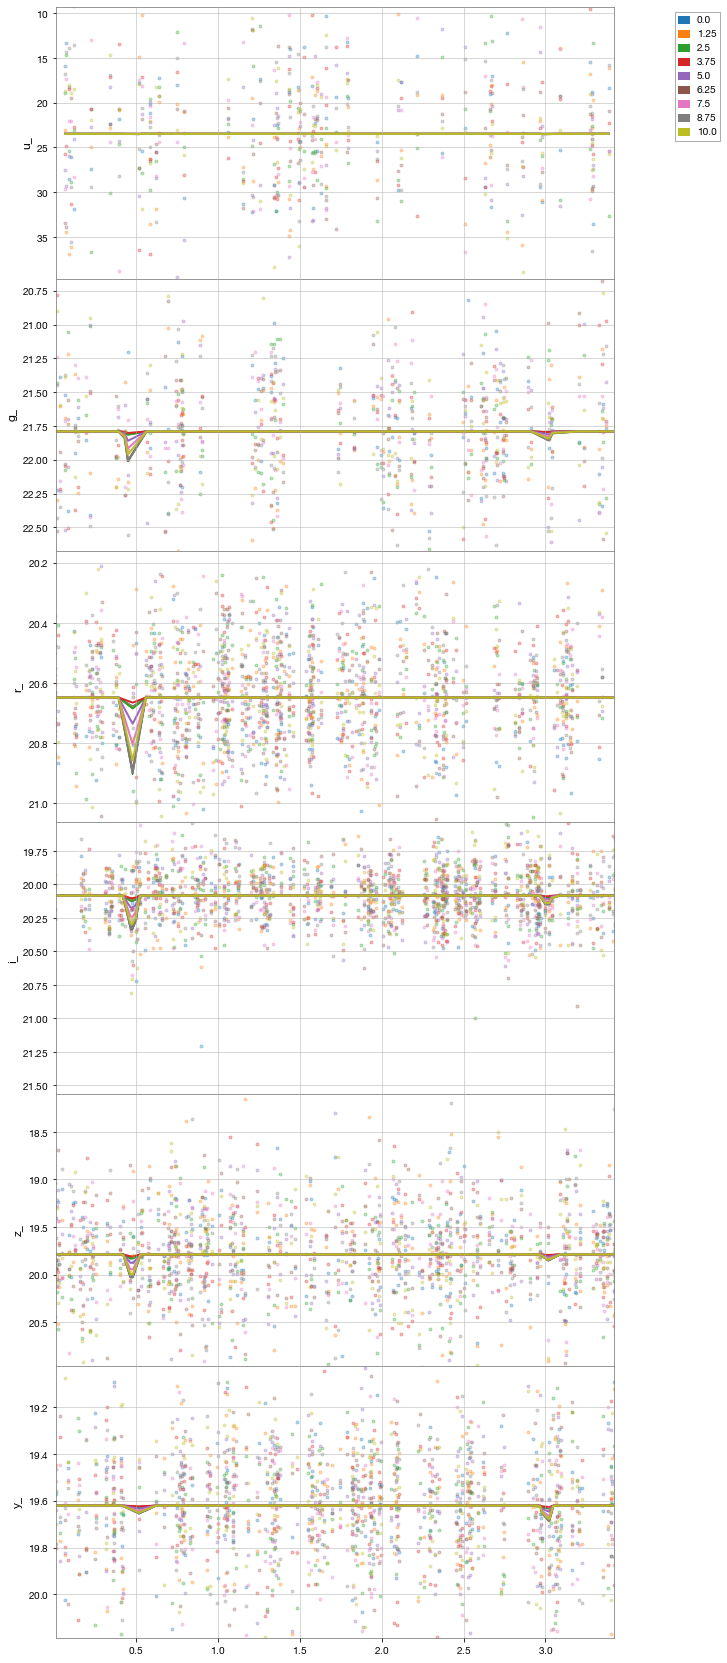

In [110]:
cmap = matplotlib.cm.get_cmap('tab10')

fig,ax = plt.subplots(6,1, figsize=(10,30), sharex = True)
for i,f in enumerate(worker.filters):

    #default
    EB.light_3 = 0.
    EB.observe(f)
    phase = (EB.obsDates[f] % EB.period)
    sort = np.argsort(phase)
    ax[i].plot(phase[sort], EB.appMag[f][sort], color='green')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)
    ax[i].set_xlim(min(phase), max(phase))
    
    #with crowding
    for j,s in enumerate(singlesFvArr):
        EB.light_3 = s[f]/(EB.Fv1[f] + EB.Fv2[f])
        EB.observe(f)
        ax[i].plot(phase[sort], EB.appMag[f][sort], color=cmap(float(j)/len(d2D)), label=d2D[j], linewidth=2)
        ax[i].plot(phase[sort], EB.appMagObs[f][sort], '.', alpha=0.3, color=cmap(float(j)/len(d2D)))
        print(i,j, d2D[j], f, EB.light_3)

plt.subplots_adjust(hspace=0)
ax[0].legend(bbox_to_anchor=(1.2,1))